In [14]:
# Mount google drive
from google.colab import drive
import gc

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install statsmodels --upgrade

In [23]:
import pandas as pd
import numpy as np
import json
import os
import statsmodels
from scipy.stats import shapiro
import statsmodels.formula.api as smf # import the formula API from statsmodels
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Import pandas from tqdm for DataFrame integration
import numpy as np
import spacy
from collections import Counter
from nltk.corpus import wordnet as wn
import nltk
import ast
nltk.download('wordnet')
nltk.download('omw-1.4')
# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [17]:
%cd ./drive/My Drive/SUNY_Poly_DSA598/datasets/FEVER/

[Errno 2] No such file or directory: './drive/My Drive/SUNY_Poly_DSA598/datasets/FEVER/'
/content/drive/My Drive/SUNY_Poly_DSA598/datasets/FEVER


In [18]:
!ls -a

AVeriTeC			 GPT_sets	     shared_task_test.jsonl
fever2-adversarial.jsonl	 paper_dev.jsonl     tabular_sets
feverous_train_challenges.jsonl  paper_test.jsonl    wiki-pages
fever-scorer			 paper_test_results


In [19]:
def load_jsonl(file_path, encoding='utf-8'):
    """Loads a JSON Lines file into a list of Python objects."""
    data = []
    with open(file_path, 'r', encoding=encoding) as f:  # Specify encoding for safety
        for line in f:
            data.append(json.loads(line))  # Parse each line individually
    return data

In [38]:
# Data paths (replace with your actual paths if different)
fever_path = "./datasets/FEVER/"
train_clf_path = f"tabular_sets/tabular_clf_paper_dev_train/v1_segmented_sentIDs_n3461_04-04_002.csv"
valid_clf_path = f"tabular_sets/tabular_clf_paper_dev_valid/v1_segmented_sentIDs_n1482_04-04_002.csv"
train_sentEx_path = f"tabular_sets/tabular_sentEx_paper_dev_train/v1_segmented_sentIDs_n3461_04-04_002.csv"
valid_sentEx_path = f"tabular_sets/tabular_sentEx_paper_dev_valid/v1_segmented_sentIDs_n1482_04-04_002.csv"
test_path = f"paper_test.jsonl"
train_path = f"paper_dev.jsonl"

# Load datasets
train_clf = pd.read_csv(train_clf_path)
valid_clf = pd.read_csv(valid_clf_path)
train_sentEx = pd.read_csv(train_sentEx_path)
valid_sentEx = pd.read_csv(valid_sentEx_path)
test_jsonl = load_jsonl(test_path)
train_jsonl = load_jsonl(train_path)

In [39]:
# Show the distribution of labels
print(f"SentEx train set label distribution:")
print(train_sentEx['label'].value_counts())
print(f"SentEx valid set label distribution:")
print(valid_sentEx['label'].value_counts())
print(f"CLF train set label distribution:")
print(train_clf['label'].value_counts())
print(f"CLF valid set label distribution:")
print(valid_clf['label'].value_counts())

# Balance the labels by reducing each to the minimum count
min_count = min(train_sentEx['label'].value_counts())
train_sentEx = train_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
min_count = min(valid_sentEx['label'].value_counts())
valid_sentEx = valid_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
min_count = min(train_clf['label'].value_counts())
train_clf = train_clf.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
min_count = min(valid_clf['label'].value_counts())
valid_clf = valid_clf.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# Show the distribution of labels after balancing
print(f"SentEx train set label distribution after balancing:")
print(train_sentEx['label'].value_counts())
print(f"SentEx valid set label distribution after balancing:")
print(valid_sentEx['label'].value_counts())
print(f"CLF train set label distribution after balancing:")
print(train_clf['label'].value_counts())
print(f"CLF valid set label distribution after balancing:")
print(valid_clf['label'].value_counts())

SentEx train set label distribution:
label
SUPPORTS           1156
REFUTES            1156
NOT ENOUGH INFO    1149
Name: count, dtype: int64
SentEx valid set label distribution:
label
SUPPORTS           495
REFUTES            495
NOT ENOUGH INFO    488
Name: count, dtype: int64
CLF train set label distribution:
label
SUPPORTS           1156
REFUTES            1156
NOT ENOUGH INFO    1149
Name: count, dtype: int64
CLF valid set label distribution:
label
SUPPORTS           496
REFUTES            496
NOT ENOUGH INFO    486
Name: count, dtype: int64
SentEx train set label distribution after balancing:
label
NOT ENOUGH INFO    1149
REFUTES            1149
SUPPORTS           1149
Name: count, dtype: int64
SentEx valid set label distribution after balancing:
label
NOT ENOUGH INFO    488
REFUTES            488
SUPPORTS           488
Name: count, dtype: int64
CLF train set label distribution after balancing:
label
NOT ENOUGH INFO    1149
REFUTES            1149
SUPPORTS           1149
Name: cou

<ipython-input-39-711202d98b5e>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sentEx = train_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
<ipython-input-39-711202d98b5e>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_sentEx = valid_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
<ipython-input-39-711202d98b5e>:17: 

In [40]:
print(train_sentEx.info())
print(valid_sentEx.info())
print(train_clf.info())
print(valid_clf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3447 non-null   int64  
 1   claim                 3447 non-null   object 
 2   evidence_items        3447 non-null   object 
 3   full_text             3447 non-null   object 
 4   label                 3447 non-null   object 
 5   syntactic_complexity  3447 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 161.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1464 non-null   int64  
 1   claim                 1464 non-null   object 
 2   evidence_items        1464 non-null   object 
 3   full_text             1464 non-null   object 
 4   

In [11]:
# plot the syntactic_complexity by label

def plot_claim_var(data, column, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y=column, data=data)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel(column)
    plt.show()

# Check for normality using Shapiro-Wilk test
def check_normality(data, column, title):
    stat, p = shapiro(data[column])
    print('Shapiro Test Results for ' + title + ':')
    print(f'Shapiro stat = {stat}, p-value = {p}')
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print("--------------------------------------------\n")


# Check for homogeneity of variance using Levene's test
from scipy.stats import levene
def check_homogeneity(data, column, title):
    groups = data.groupby('label')[column].apply(list)
    stat, p = levene(*groups)
    print('Levene Test Results for ' + title + ':')
    print(f'Levene stat = {stat}, p-value = {p}')
    alpha = 0.05
    if p > alpha:
        print('Homogeneity of variance (fail to reject H0)')
    else:
        print('Not homogenous (reject H0)')
    print("--------------------------------------------\n")

# Kruskal-Wallis test
def kruskal_test(data, column, title):
    groups = data.groupby('label')[column].apply(list)
    stat, p = kruskal(*groups)
    print('Kruskal-Wallis Test Results for ' + title + ':')
    print(f'Kruskal stat = {stat}, p-value = {p}')
    alpha = 0.05
    if p > alpha:
        print('Median ranks are equal (fail to reject H0)')
    else:
        print('Median ranks are not equal (reject H0)')
    print("--------------------------------------------\n")


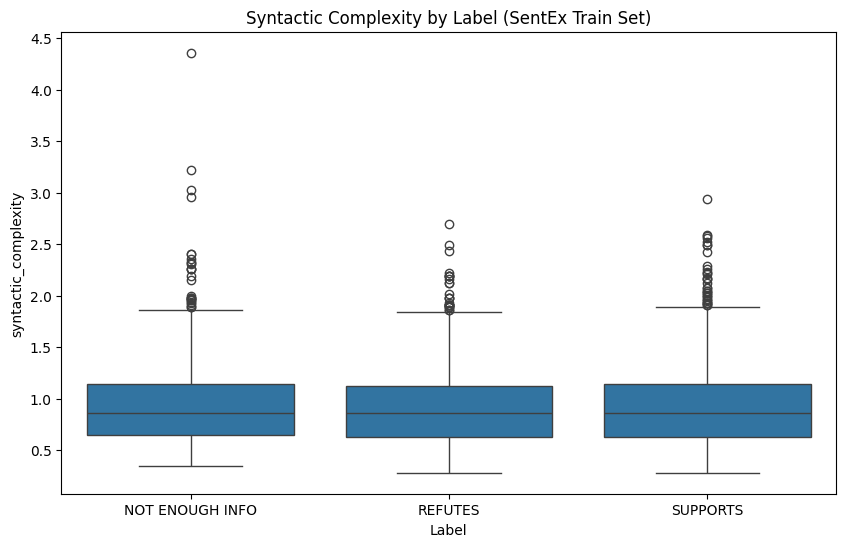

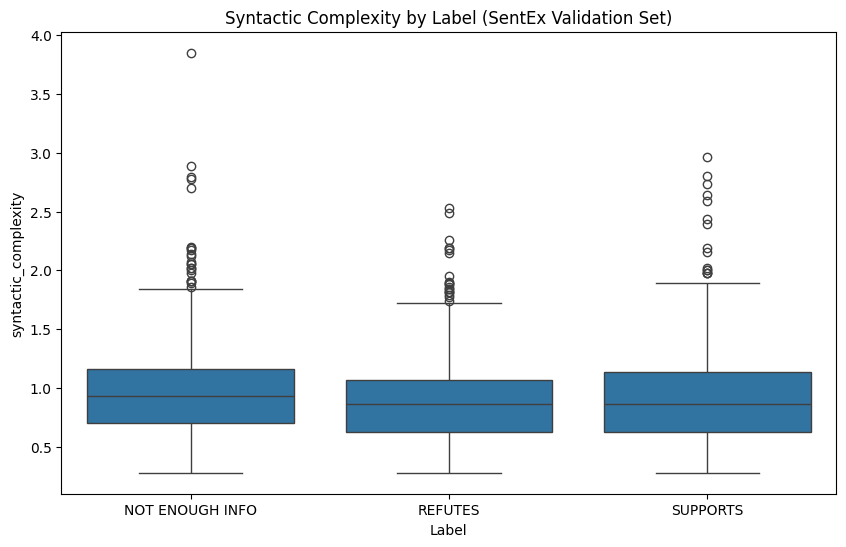

Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.9269430363398228, p-value = 4.5251846689566004e-38
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.9089854320682252, p-value = 1.0264556189164883e-28
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.9314841764268582, p-value = 3.832315698005129e-37
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.9225483902850047, p-value = 9.800787919790108e-27
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 0.3342790648033196, p-value = 0.7158772083506754
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene 

In [12]:
plot_claim_var(train_sentEx, 'syntactic_complexity', 'Syntactic Complexity by Label (SentEx Train Set)')
plot_claim_var(valid_sentEx, 'syntactic_complexity', 'Syntactic Complexity by Label (SentEx Validation Set)')

check_normality(train_sentEx, 'syntactic_complexity', 'SentEx Train Set')
check_normality(valid_sentEx, 'syntactic_complexity', 'SentEx Validation Set')
check_normality(train_clf, 'syntactic_complexity', 'CLF Train Set')
check_normality(valid_clf, 'syntactic_complexity', 'CLF Validation Set')
check_homogeneity(train_sentEx, 'syntactic_complexity', 'SentEx Train Set')
check_homogeneity(valid_sentEx, 'syntactic_complexity', 'SentEx Validation Set')
check_homogeneity(train_clf, 'syntactic_complexity', 'CLF Train Set')
check_homogeneity(valid_clf, 'syntactic_complexity', 'CLF Validation Set')


"""
Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.9269430363398228, p-value = 4.5251846689566004e-38
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.9089854320682252, p-value = 1.0264556189164883e-28
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.9314841764268582, p-value = 3.832315698005129e-37
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.9225483902850047, p-value = 9.800787919790108e-27
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 0.3342790648033196, p-value = 0.7158772083506754
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Test Results for SentEx Validation Set:
Levene stat = 2.0819233732282334, p-value = 0.1250599246295826
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Test Results for CLF Train Set:
Levene stat = 0.9065744063347341, p-value = 0.40400183871003936
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Test Results for CLF Validation Set:
Levene stat = 1.6611966525480244, p-value = 0.19027156835945563
Homogeneity of variance (fail to reject H0)
--------------------------------------------
"""

In [13]:
# Ordinal encode the label column
train_sentEx['label'] = train_sentEx['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})
valid_sentEx['label'] = valid_sentEx['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})
train_clf['label'] = train_clf['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})
valid_clf['label'] = valid_clf['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})


# Perform an ANOVA on label and syntactic_complexity using statsmodels
model = smf.ols('label ~ syntactic_complexity', data=train_sentEx).fit() #refer to formula API using the alias smf
print(model.summary())
print("--------------------------------------------\n")

# Perform a Kruskal-Wallis test
kruskal_test(train_sentEx, 'syntactic_complexity', 'SentEx Train Set')
kruskal_test(valid_sentEx, 'syntactic_complexity', 'SentEx Validation Set')
kruskal_test(train_clf, 'syntactic_complexity', 'CLF Train Set')
kruskal_test(valid_clf, 'syntactic_complexity', 'CLF Validation Set')

"""
                            OLS Regression Results
==============================================================================
Dep. Variable:                  label   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.343
Date:                Sun, 11 May 2025   Prob (F-statistic):             0.0372
Time:                        22:02:09   Log-Likelihood:                -4190.1
No. Observations:                3447   AIC:                             8384.
Df Residuals:                    3445   BIC:                             8396.
Df Model:                           1
Covariance Type:            nonrobust
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9332      0.035     26.692      0.000       0.865       1.002
syntactic_complexity     0.0721      0.035      2.084      0.037       0.004       0.140
==============================================================================
Omnibus:                    21986.151   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              321.634
Skew:                           0.000   Prob(JB):                     1.44e-70
Kurtosis:                       1.504   Cond. No.                         4.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
--------------------------------------------

Kruskal-Wallis Test Results for SentEx Train Set:
Kruskal stat = 3.0091424936687416, p-value = 0.22211250485906037
Median ranks are equal (fail to reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for SentEx Validation Set:
Kruskal stat = 8.665534103752224, p-value = 0.013131162565795367
Median ranks are not equal (reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for CLF Train Set:
Kruskal stat = 2.3734431521302146, p-value = 0.30522026702314636
Median ranks are equal (fail to reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for CLF Validation Set:
Kruskal stat = 2.7996513069034163, p-value = 0.24663996101917604
Median ranks are equal (fail to reject H0)
--------------------------------------------
"""

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.343
Date:                Sun, 11 May 2025   Prob (F-statistic):             0.0372
Time:                        22:02:09   Log-Likelihood:                -4190.1
No. Observations:                3447   AIC:                             8384.
Df Residuals:                    3445   BIC:                             8396.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9332 

'\n\n\n'

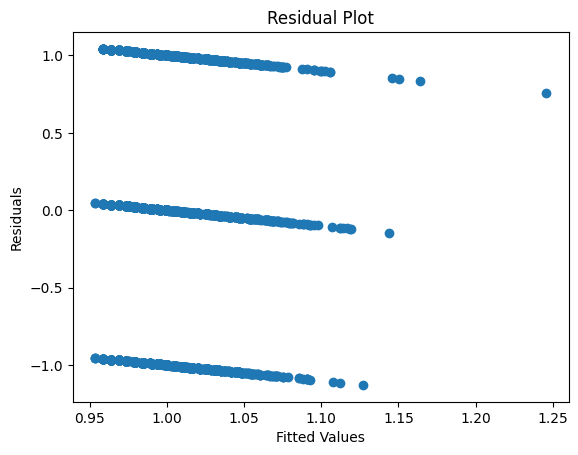

In [ ]:
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Parse tree depth

In [ ]:
def calculate_parse_tree_depth(sentence):
    """
    Calculate the depth of the dependency parse tree for a given sentence.
    """
    doc = nlp(sentence)
    def get_depth(token):
        if not list(token.children):  # If the token has no children, depth is 1
            return 1
        return 1 + max(get_depth(child) for child in token.children)

    # Get the depth of the root token
    return max(get_depth(sent.root) for sent in doc.sents)


# Calculate parse tree depth for each sentence in the dataset with a progress bar
def calculate_parse_tree_depth_for_dataset(dataset):
    tqdm.pandas(desc="Calculating parse tree depth")
    dataset['parse_tree_depth'] = dataset['claim'].progress_apply(calculate_parse_tree_depth)
    return dataset


for dataset, name in zip([train_sentEx, valid_sentEx, train_clf, valid_clf],
                      ['train_sentEx', 'valid_sentEx', 'train_clf', 'valid_clf']):
    dataset = calculate_parse_tree_depth_for_dataset(dataset)
    # Save the updated dataset
    dataset.to_csv(f"{name}_with_parse_tree_depth.csv", index=False)
    print(f"Parse tree depth statistics for {name}:")
    print(dataset['parse_tree_depth'].describe())
    print("--------------------------------------------\n")

"""
Calculating parse tree depth: 100%|██████████| 3447/3447 [00:26<00:00, 131.10it/s]
Parse tree depth statistics for train_sentEx:
count    3447.000000
mean        4.303452
std         1.298755
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        13.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------

Calculating parse tree depth: 100%|██████████| 1464/1464 [00:11<00:00, 131.25it/s]
Parse tree depth statistics for valid_sentEx:
count    1464.000000
mean        4.290301
std         1.289217
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        12.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------

Calculating parse tree depth: 100%|██████████| 3447/3447 [00:24<00:00, 140.63it/s]
Parse tree depth statistics for train_clf:
count    3447.000000
mean        4.284305
std         1.297726
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        11.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------

Calculating parse tree depth: 100%|██████████| 1458/1458 [00:09<00:00, 147.16it/s]Parse tree depth statistics for valid_clf:
count    1458.000000
mean        4.202332
std         1.209466
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        11.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------
"""

Calculating parse tree depth: 100%|██████████| 3447/3447 [00:26<00:00, 131.10it/s]


Parse tree depth statistics for train_sentEx:
count    3447.000000
mean        4.303452
std         1.298755
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        13.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------



Calculating parse tree depth: 100%|██████████| 1464/1464 [00:11<00:00, 131.25it/s]


Parse tree depth statistics for valid_sentEx:
count    1464.000000
mean        4.290301
std         1.289217
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        12.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------



Calculating parse tree depth: 100%|██████████| 3447/3447 [00:24<00:00, 140.63it/s]


Parse tree depth statistics for train_clf:
count    3447.000000
mean        4.284305
std         1.297726
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        11.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------



Calculating parse tree depth: 100%|██████████| 1458/1458 [00:09<00:00, 147.16it/s]

Parse tree depth statistics for valid_clf:
count    1458.000000
mean        4.202332
std         1.209466
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        11.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------



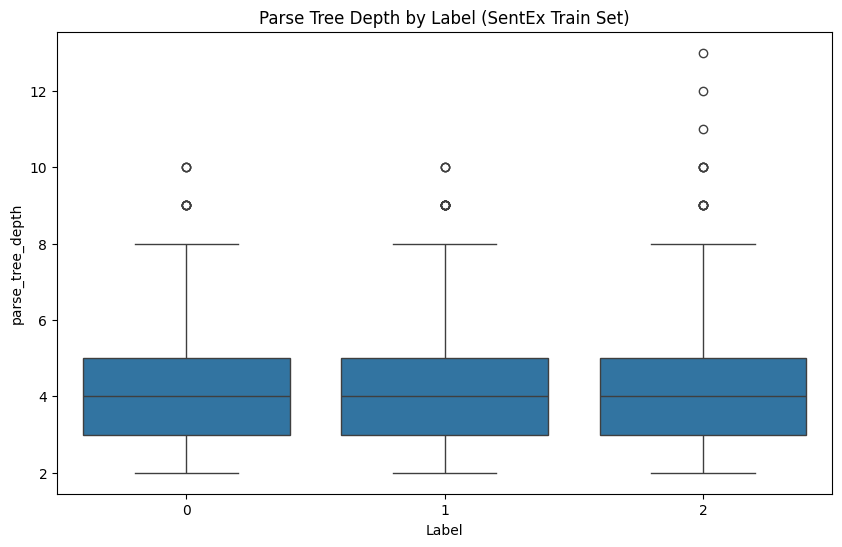

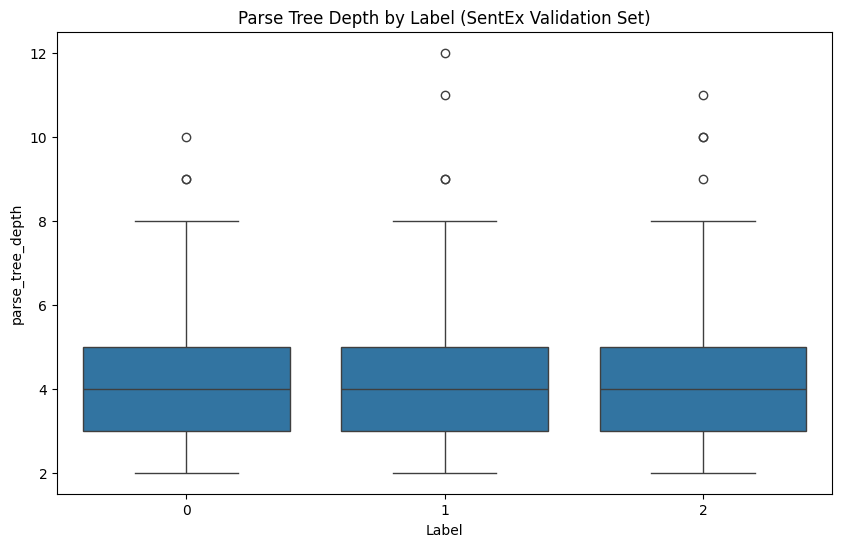

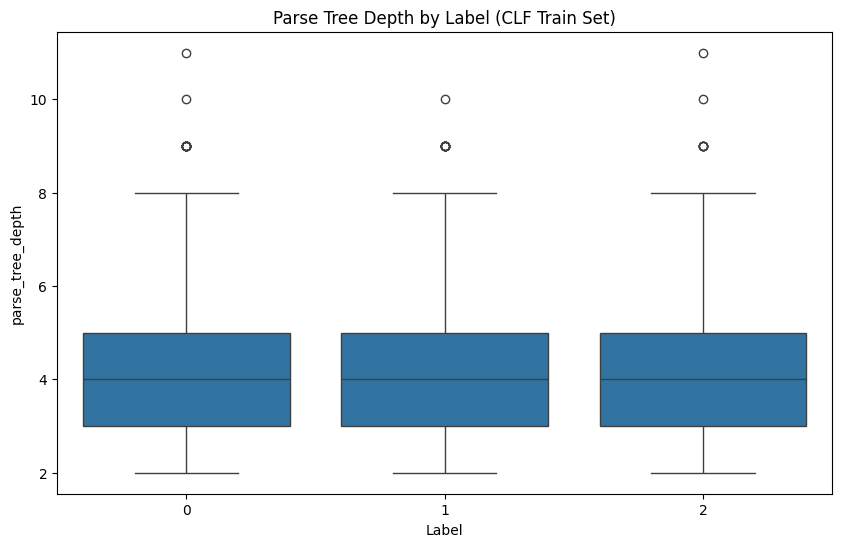

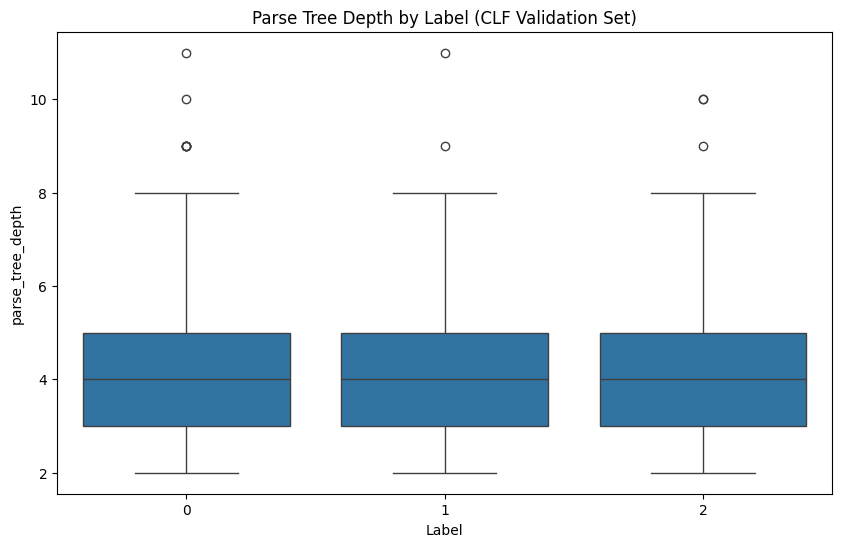

Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.8541980045619905, p-value = 8.083416919027425e-49
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.8618641938584015, p-value = 4.9786427651563084e-34
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.8658857083064015, p-value = 1.9097128228390212e-47
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.8445885852648509, p-value = 1.48532946222568e-35
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 0.9636214635762388, p-value = 0.38161159847036896
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene 

In [ ]:
# plot parse_tree_depth
plot_claim_var(train_sentEx, 'parse_tree_depth', 'Parse Tree Depth by Label (SentEx Train Set)')
plot_claim_var(valid_sentEx, 'parse_tree_depth', 'Parse Tree Depth by Label (SentEx Validation Set)')
plot_claim_var(train_clf, 'parse_tree_depth', 'Parse Tree Depth by Label (CLF Train Set)')
plot_claim_var(valid_clf, 'parse_tree_depth', 'Parse Tree Depth by Label (CLF Validation Set)')

# Check normality
check_normality(train_sentEx, 'parse_tree_depth', 'SentEx Train Set')
check_normality(valid_sentEx, 'parse_tree_depth', 'SentEx Validation Set')
check_normality(train_clf, 'parse_tree_depth', 'CLF Train Set')
check_normality(valid_clf, 'parse_tree_depth', 'CLF Validation Set')

# Check homegeneity of variance
check_homogeneity(train_sentEx, 'parse_tree_depth', 'SentEx Train Set')
check_homogeneity(valid_sentEx, 'parse_tree_depth', 'SentEx Validation Set')
check_homogeneity(train_clf, 'parse_tree_depth', 'CLF Train Set')
check_homogeneity(valid_clf, 'parse_tree_depth', 'CLF Validation Set')

"""
Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.8541980045619905, p-value = 8.083416919027425e-49
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.8618641938584015, p-value = 4.9786427651563084e-34
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.8658857083064015, p-value = 1.9097128228390212e-47
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.8445885852648509, p-value = 1.48532946222568e-35
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 0.9636214635762388, p-value = 0.38161159847036896
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Test Results for SentEx Validation Set:
Levene stat = 1.2961521675302938, p-value = 0.2738968724240058
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Test Results for CLF Train Set:
Levene stat = 0.14610278491665313, p-value = 0.8640742406126276
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Test Results for CLF Validation Set:
Levene stat = 0.3079030901543714, p-value = 0.7350344200028971
Homogeneity of variance (fail to reject H0)
--------------------------------------------
"""

In [ ]:
print("OLS for SentEx Train set:")
parse_model = smf.ols('label ~ parse_tree_depth', data=train_sentEx).fit() #refer to formula API using the alias smf
print(parse_model.summary())
print("--------------------------------------------\n")

# Kruskal Wallis test
kruskal_test(train_sentEx, 'parse_tree_depth', 'SentEx Train Set')
kruskal_test(valid_sentEx, 'parse_tree_depth', 'SentEx Validation Set')
kruskal_test(train_clf, 'parse_tree_depth', 'CLF Train Set')
kruskal_test(valid_clf, 'parse_tree_depth', 'CLF Validation Set')


"""
OLS for train_sentEx:
                            OLS Regression Results
==============================================================================
Dep. Variable:                  label   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6194
Date:                Sat, 12 Apr 2025   Prob (F-statistic):              0.431
Time:                        20:40:43   Log-Likelihood:                -4192.0
No. Observations:                3447   AIC:                             8388.
Df Residuals:                    3445   BIC:                             8400.
Df Model:                           1
Covariance Type:            nonrobust
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.9637      0.048     20.015      0.000       0.869       1.058
parse_tree_depth     0.0084      0.011      0.787      0.431      -0.013       0.029
==============================================================================
Omnibus:                    21795.241   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.932
Skew:                           0.001   Prob(JB):                     7.52e-71
Kurtosis:                       1.501   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
--------------------------------------------

Kruskal-Wallis Test Results for SentEx Train Set:
Kruskal stat = 3.983521001022517, p-value = 0.1364549847891906
Median ranks are equal (fail to reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for SentEx Validation Set:
Kruskal stat = 6.4305109247960885, p-value = 0.04014507695592895
Median ranks are not equal (reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for CLF Train Set:
Kruskal stat = 0.5932889201181477, p-value = 0.743308241155362
Median ranks are equal (fail to reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for CLF Validation Set:
Kruskal stat = 0.11144296764858029, p-value = 0.9458025205112446
Median ranks are equal (fail to reject H0)
--------------------------------------------
"""

OLS for train_sentEx:
                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6194
Date:                Sat, 12 Apr 2025   Prob (F-statistic):              0.431
Time:                        20:40:43   Log-Likelihood:                -4192.0
No. Observations:                3447   AIC:                             8388.
Df Residuals:                    3445   BIC:                             8400.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         

In [ ]:
# Semantic complexity measures (e.g., number of distinct concepts, depth of the semantic network).

def calculate_semantic_complexity(sentence):
    """
    Calculate semantic complexity of a sentence based on WordNet.
    """
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_stop and not token.is_punct]

    # Get synsets for each word
    synsets = [wn.synsets(word) for word in words]

    # Flatten the list of synsets
    synsets_flat = [synset for sublist in synsets for synset in sublist]

    # Count distinct concepts (synsets)
    distinct_concepts = len(set(synsets_flat))

    # Calculate depth of the semantic network
    depth = sum([synset.min_depth() for synset in synsets_flat if synset])

    return distinct_concepts, depth

# Calculate semantic complexity for each sentence in the dataset with a progress bar
def calculate_semantic_complexity_for_dataset(dataset, column='claim'):
    tqdm.pandas(desc="Calculating semantic complexity")
    dataset[[f'distinct_concepts_{column}', f'semantic_depth_{column}']] = dataset[column].progress_apply(calculate_semantic_complexity).apply(pd.Series)
    return dataset


In [ ]:
for dataset, name in zip([train_sentEx, valid_sentEx, train_clf, valid_clf],
                      ['train_sentEx', 'valid_sentEx', 'train_clf', 'valid_clf']):
    dataset = calculate_semantic_complexity_for_dataset(dataset)
    # Save the updated dataset
    dataset.to_csv(f"{name}_with_semantic_complexity.csv", index=False)
    print(f"Semantic complexity statistics for {name}:")
    print(dataset[['distinct_concepts', 'semantic_depth']].describe())
    print("--------------------------------------------\n")



In [ ]:
for dataset, name in zip([train_sentEx, valid_sentEx, train_clf, valid_clf],
                      ['train_sentEx', 'valid_sentEx', 'train_clf', 'valid_clf']):
    print(f"Semantic complexity statistics for {name}:")
    print(dataset[['distinct_concepts', 'semantic_depth']].describe())
    print("--------------------------------------------\n")

    """
    Semantic complexity statistics for train_sentEx:
       distinct_concepts  semantic_depth
count        3447.000000     3447.000000
mean           26.827966      108.927183
std            20.011104       78.507710
min             0.000000        0.000000
25%            13.000000       51.000000
50%            22.000000       91.000000
75%            36.000000      148.000000
max           219.000000     1016.000000
--------------------------------------------

Semantic complexity statistics for valid_sentEx:
       distinct_concepts  semantic_depth
count        1464.000000     1464.000000
mean           26.673497      110.069672
std            20.139634       81.544686
min             0.000000        0.000000
25%            12.000000       49.000000
50%            22.000000       93.000000
75%            36.000000      149.000000
max           191.000000      861.000000
--------------------------------------------

Semantic complexity statistics for train_clf:
       distinct_concepts  semantic_depth
count        3447.000000     3447.000000
mean           26.527415      108.253554
std            19.233854       77.298898
min             0.000000        0.000000
25%            12.000000       49.500000
50%            22.000000       90.000000
75%            36.000000      152.000000
max           156.000000      606.000000
--------------------------------------------

Semantic complexity statistics for valid_clf:
       distinct_concepts  semantic_depth
count        1458.000000     1458.000000
mean           26.175583      107.400549
std            19.324258       77.874783
min             0.000000        0.000000
25%            12.000000       50.000000
50%            21.500000       89.000000
75%            35.000000      145.000000
max           123.000000      501.000000
--------------------------------------------
"""

Semantic complexity statistics for train_sentEx:
       distinct_concepts  semantic_depth
count        3447.000000     3447.000000
mean           26.827966      108.927183
std            20.011104       78.507710
min             0.000000        0.000000
25%            13.000000       51.000000
50%            22.000000       91.000000
75%            36.000000      148.000000
max           219.000000     1016.000000
--------------------------------------------

Semantic complexity statistics for valid_sentEx:
       distinct_concepts  semantic_depth
count        1464.000000     1464.000000
mean           26.673497      110.069672
std            20.139634       81.544686
min             0.000000        0.000000
25%            12.000000       49.000000
50%            22.000000       93.000000
75%            36.000000      149.000000
max           191.000000      861.000000
--------------------------------------------

Semantic complexity statistics for train_clf:
       distinct_concepts  

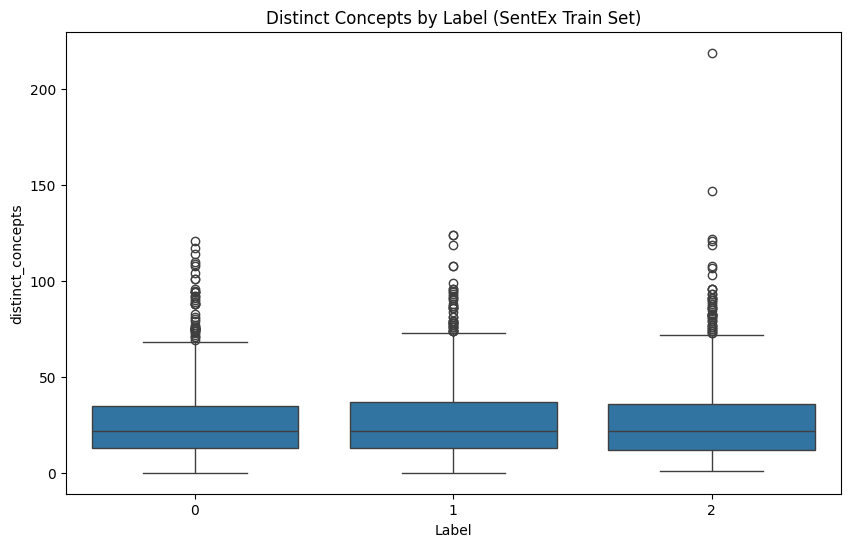

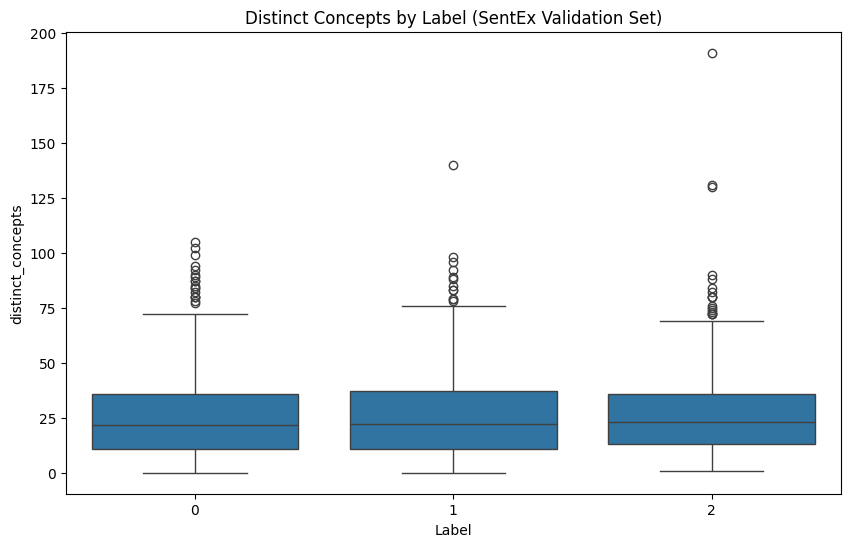

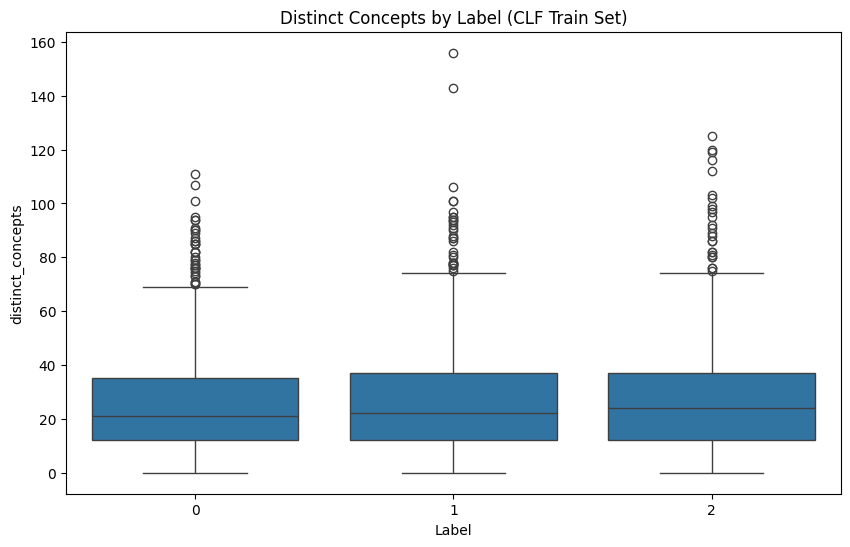

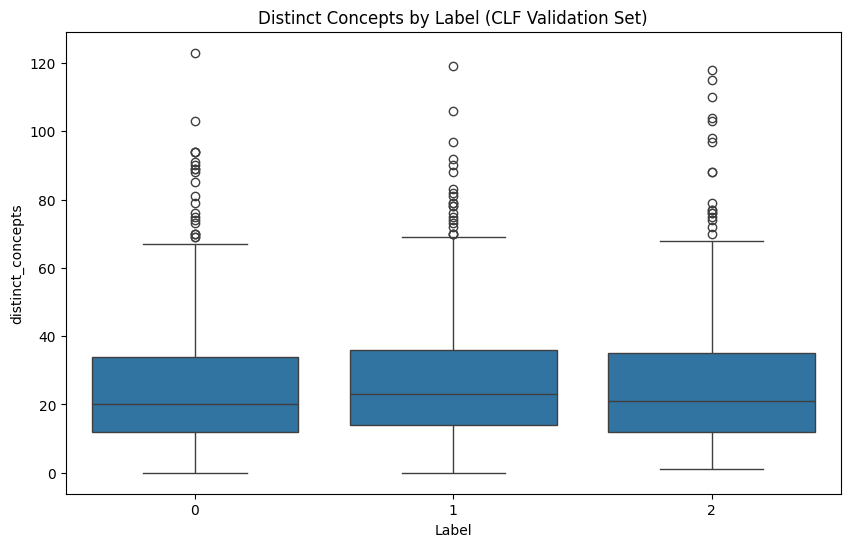

Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.8791320692588088, p-value = 9.160328641311294e-46
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.8843520789358179, p-value = 1.0431949186905078e-31
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.9061436321992045, p-value = 8.30159494915953e-42
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.8816346458266718, p-value = 5.991497505336822e-32
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 0.20979077219304143, p-value = 0.8107642206305576
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene T

In [ ]:
# plot semantic complexity
plot_claim_var(train_sentEx, 'distinct_concepts', 'Distinct Concepts by Label (SentEx Train Set)')
plot_claim_var(valid_sentEx, 'distinct_concepts', 'Distinct Concepts by Label (SentEx Validation Set)')
plot_claim_var(train_clf, 'distinct_concepts', 'Distinct Concepts by Label (CLF Train Set)')
plot_claim_var(valid_clf, 'distinct_concepts', 'Distinct Concepts by Label (CLF Validation Set)')

# Check normality
check_normality(train_sentEx, 'distinct_concepts', 'SentEx Train Set')
check_normality(valid_sentEx, 'distinct_concepts', 'SentEx Validation Set')
check_normality(train_clf, 'distinct_concepts', 'CLF Train Set')
check_normality(valid_clf, 'distinct_concepts', 'CLF Validation Set')

# Check homogeneity of variance
check_homogeneity(train_sentEx, 'distinct_concepts', 'SentEx Train Set')
check_homogeneity(valid_sentEx, 'distinct_concepts', 'SentEx Validation Set')
check_homogeneity(train_clf, 'distinct_concepts', 'CLF Train Set')
check_homogeneity(valid_clf, 'distinct_concepts', 'CLF Validation Set')

semantic_model = smf.ols('label ~ distinct_concepts', data=train_sentEx).fit() #refer to formula API using the alias smf
print(semantic_model.summary())

# Kruskal Wallis test
kruskal_test(train_sentEx, 'distinct_concepts', 'SentEx Train Set')
kruskal_test(valid_sentEx, 'distinct_concepts', 'SentEx Validation Set')
kruskal_test(train_clf, 'distinct_concepts', 'CLF Train Set')
kruskal_test(valid_clf, 'distinct_concepts', 'CLF Validation Set')


"""
Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.8791320692588088, p-value = 9.160328641311294e-46
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.8843520789358179, p-value = 1.0431949186905078e-31
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.9061436321992045, p-value = 8.30159494915953e-42
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.8816346458266718, p-value = 5.991497505336822e-32
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 0.20979077219304143, p-value = 0.8107642206305576
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Test Results for SentEx Validation Set:
Levene stat = 0.7823533189194855, p-value = 0.4575200024038997
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Test Results for CLF Train Set:
Levene stat = 1.9293120764549125, p-value = 0.14540503413889827
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Test Results for CLF Validation Set:
Levene stat = 0.07388070254849172, p-value = 0.9287859726669764
Homogeneity of variance (fail to reject H0)
--------------------------------------------

                            OLS Regression Results
==============================================================================
Dep. Variable:                  label   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2000
Date:                Sat, 12 Apr 2025   Prob (F-statistic):              0.655
Time:                        20:38:37   Log-Likelihood:                -4192.2
No. Observations:                3447   AIC:                             8388.
Df Residuals:                    3445   BIC:                             8401.
Df Model:                           1
Covariance Type:            nonrobust
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.9917      0.023     42.619      0.000       0.946       1.037
distinct_concepts     0.0003      0.001      0.447      0.655      -0.001       0.002
==============================================================================
Omnibus:                    21774.097   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              323.078
Skew:                           0.000   Prob(JB):                     6.99e-71
Kurtosis:                       1.500   Cond. No.                         56.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
Kruskal-Wallis Test Results for SentEx Train Set:
Kruskal stat = 0.45836535043548216, p-value = 0.7951832599614024
Median ranks are equal (fail to reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for SentEx Validation Set:
Kruskal stat = 1.061503381741668, p-value = 0.588162686946892
Median ranks are equal (fail to reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for CLF Train Set:
Kruskal stat = 2.0946600004856055, p-value = 0.35087333126256914
Median ranks are equal (fail to reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for CLF Validation Set:
Kruskal stat = 4.624000060465103, p-value = 0.09906292445182231
Median ranks are equal (fail to reject H0)
--------------------------------------------
"""

In [ ]:
# Calculate semantic complexity for all evidence sentences concatenated into a single string

for dataset, name in zip([train_sentEx, valid_sentEx, train_clf, valid_clf],
                      ['train_sentEx', 'valid_sentEx', 'train_clf', 'valid_clf']):
    dataset = calculate_semantic_complexity_for_dataset(dataset, column='evidence_sentences')
    # Save the updated dataset
    dataset.to_csv(f"tabular_sets/tabular_paper_dev_add_claim_metrics/{name}_with_evidence_semantic_complexity.csv", index=False)
    print(f"Evidence semantic complexity statistics for {name}:")
    print(dataset[['distinct_concepts_evidence_sentences', 'semantic_depth_evidence_sentences']].describe())
    print("--------------------------------------------\n")

    """
    Calculating semantic complexity: 100%|██████████| 3447/3447 [01:42<00:00, 33.65it/s]
Evidence semantic complexity statistics for train_sentEx:
       distinct_concepts_evidence_sentences  semantic_depth_evidence_sentences
count                           3447.000000                        3447.000000
mean                             163.698288                         966.906005
std                              131.753402                        1041.945984
min                                0.000000                           0.000000
25%                               69.000000                         409.000000
50%                              126.000000                         728.000000
75%                              232.000000                        1243.000000
max                             1974.000000                       25224.000000
--------------------------------------------

Calculating semantic complexity: 100%|██████████| 1464/1464 [00:45<00:00, 32.39it/s]
Evidence semantic complexity statistics for valid_sentEx:
       distinct_concepts_evidence_sentences  semantic_depth_evidence_sentences
count                           1464.000000                        1464.000000
mean                             163.605874                         959.539617
std                              123.085263                         878.669845
min                                2.000000                          15.000000
25%                               71.000000                         433.500000
50%                              129.000000                         735.000000
75%                              226.000000                        1250.250000
max                             1023.000000                        9184.000000
--------------------------------------------

Calculating semantic complexity: 100%|██████████| 3447/3447 [01:41<00:00, 34.03it/s]
Evidence semantic complexity statistics for train_clf:
       distinct_concepts_evidence_sentences  semantic_depth_evidence_sentences
count                           3447.000000                        3447.000000
mean                             159.419495                         943.025239
std                              119.588161                         859.070286
min                                1.000000                           7.000000
25%                               68.000000                         416.500000
50%                              127.000000                         730.000000
75%                              227.000000                        1243.500000
max                             1198.000000                       11166.000000
--------------------------------------------

Calculating semantic complexity: 100%|██████████| 1458/1458 [00:43<00:00, 33.25it/s]
Evidence semantic complexity statistics for valid_clf:
       distinct_concepts_evidence_sentences  semantic_depth_evidence_sentences
count                           1458.000000                        1458.000000
mean                             161.840878                         966.991084
std                              124.661835                         956.830789
min                                0.000000                           0.000000
25%                               67.000000                         424.000000
50%                              129.000000                         726.000000
75%                              226.000000                        1242.000000
max                             1293.000000                       15192.000000
--------------------------------------------
"""

Calculating semantic complexity: 100%|██████████| 3447/3447 [01:42<00:00, 33.65it/s]


Evidence semantic complexity statistics for train_sentEx:
       distinct_concepts_evidence_sentences  semantic_depth_evidence_sentences
count                           3447.000000                        3447.000000
mean                             163.698288                         966.906005
std                              131.753402                        1041.945984
min                                0.000000                           0.000000
25%                               69.000000                         409.000000
50%                              126.000000                         728.000000
75%                              232.000000                        1243.000000
max                             1974.000000                       25224.000000
--------------------------------------------



Calculating semantic complexity: 100%|██████████| 1464/1464 [00:45<00:00, 32.39it/s]


Evidence semantic complexity statistics for valid_sentEx:
       distinct_concepts_evidence_sentences  semantic_depth_evidence_sentences
count                           1464.000000                        1464.000000
mean                             163.605874                         959.539617
std                              123.085263                         878.669845
min                                2.000000                          15.000000
25%                               71.000000                         433.500000
50%                              129.000000                         735.000000
75%                              226.000000                        1250.250000
max                             1023.000000                        9184.000000
--------------------------------------------



Calculating semantic complexity: 100%|██████████| 3447/3447 [01:41<00:00, 34.03it/s]


Evidence semantic complexity statistics for train_clf:
       distinct_concepts_evidence_sentences  semantic_depth_evidence_sentences
count                           3447.000000                        3447.000000
mean                             159.419495                         943.025239
std                              119.588161                         859.070286
min                                1.000000                           7.000000
25%                               68.000000                         416.500000
50%                              127.000000                         730.000000
75%                              227.000000                        1243.500000
max                             1198.000000                       11166.000000
--------------------------------------------



Calculating semantic complexity: 100%|██████████| 1458/1458 [00:43<00:00, 33.25it/s]


Evidence semantic complexity statistics for valid_clf:
       distinct_concepts_evidence_sentences  semantic_depth_evidence_sentences
count                           1458.000000                        1458.000000
mean                             161.840878                         966.991084
std                              124.661835                         956.830789
min                                0.000000                           0.000000
25%                               67.000000                         424.000000
50%                              129.000000                         726.000000
75%                              226.000000                        1242.000000
max                             1293.000000                       15192.000000
--------------------------------------------



In [42]:
train_sentEx = pd.read_csv(f"tabular_sets/tabular_paper_dev_add_claim_metrics/train_sentEx_with_evidence_semantic_complexity.csv")
valid_sentEx = pd.read_csv(f"tabular_sets/tabular_paper_dev_add_claim_metrics/valid_sentEx_with_evidence_semantic_complexity.csv")
train_clf = pd.read_csv(f"tabular_sets/tabular_paper_dev_add_claim_metrics/train_clf_with_evidence_semantic_complexity.csv")
valid_clf = pd.read_csv(f"tabular_sets/tabular_paper_dev_add_claim_metrics/valid_clf_with_evidence_semantic_complexity.csv")

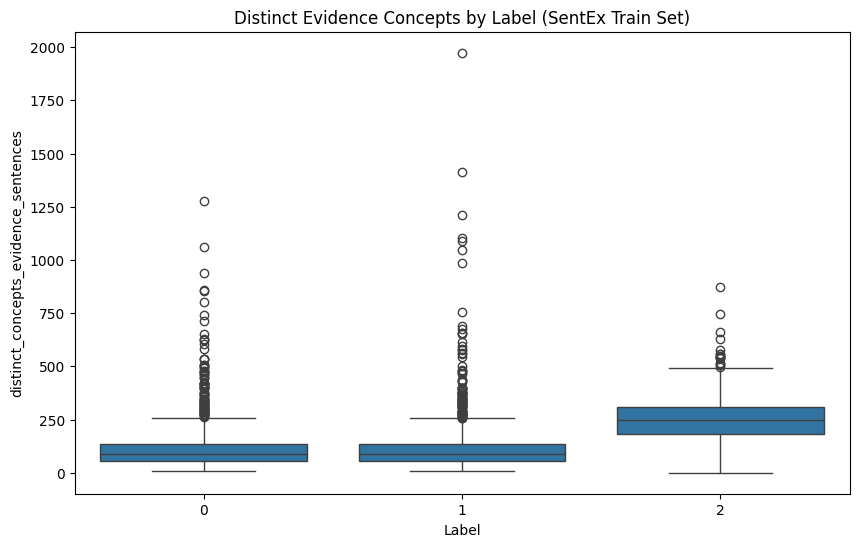

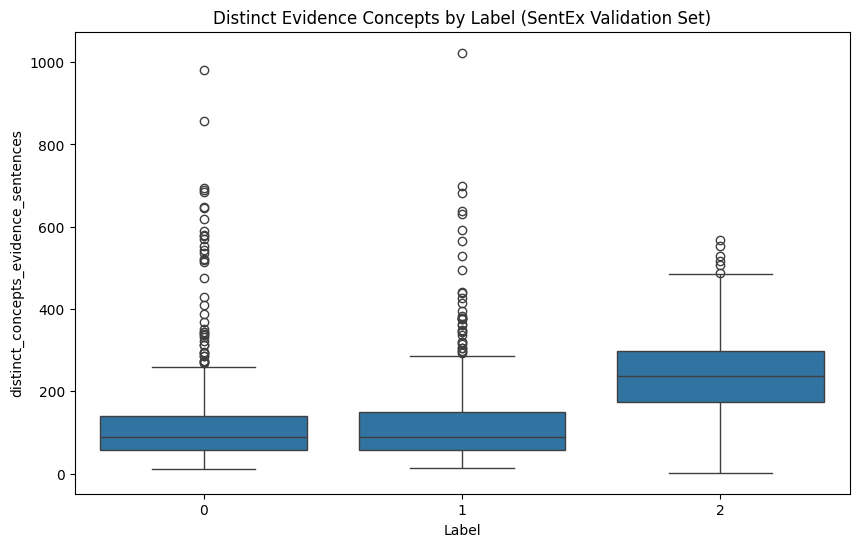

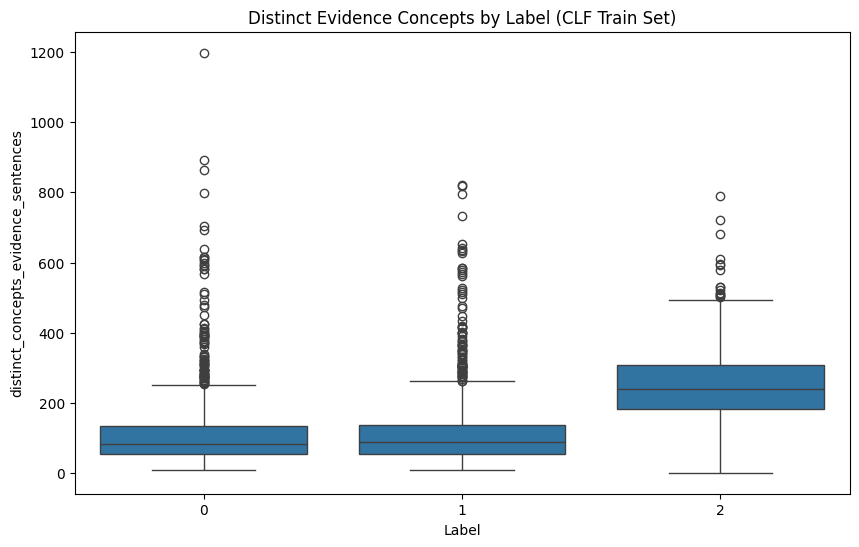

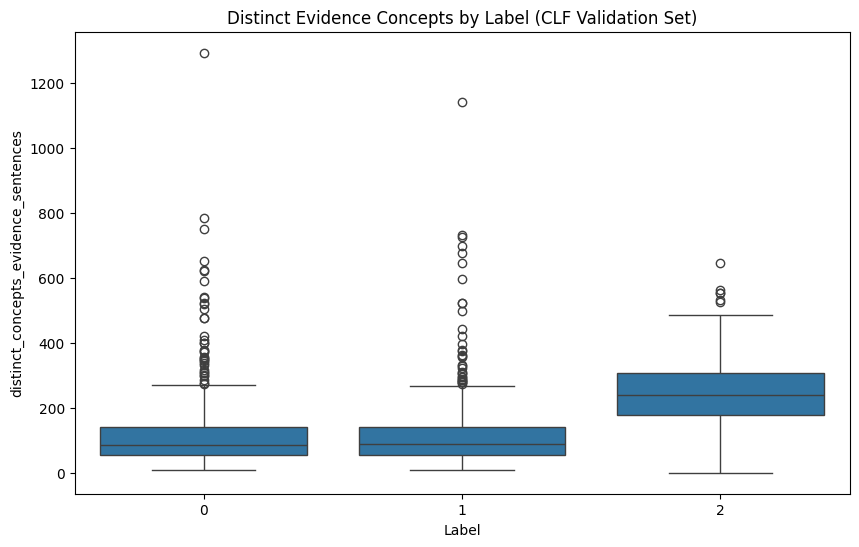

In [43]:
# Visualize the distribution of distinct concepts and semantic depth for evidence sentences
plot_claim_var(train_sentEx, 'distinct_concepts_evidence_sentences', 'Distinct Evidence Concepts by Label (SentEx Train Set)')
plot_claim_var(valid_sentEx, 'distinct_concepts_evidence_sentences', 'Distinct Evidence Concepts by Label (SentEx Validation Set)')
plot_claim_var(train_clf, 'distinct_concepts_evidence_sentences', 'Distinct Evidence Concepts by Label (CLF Train Set)')
plot_claim_var(valid_clf, 'distinct_concepts_evidence_sentences', 'Distinct Evidence Concepts by Label (CLF Validation Set)')

In [ ]:
# ANOVA with interation between distinct_concepts and distinct_concepts_evidence_sentences, and semantic_complexity and distinct_concepts_evidence_sene
# Check for normality using Shapiro-Wilk test

check_normality(train_sentEx, 'distinct_concepts_evidence_sentences', 'SentEx Train Set')
check_normality(valid_sentEx, 'distinct_concepts_evidence_sentences', 'SentEx Validation Set')
check_normality(train_clf, 'distinct_concepts_evidence_sentences', 'CLF Train Set')
check_normality(valid_clf, 'distinct_concepts_evidence_sentences', 'CLF Validation Set')
# Check for homogeneity of variance using Levene's test
check_homogeneity(train_sentEx, 'distinct_concepts_evidence_sentences', 'SentEx Train Set')
check_homogeneity(valid_sentEx, 'distinct_concepts_evidence_sentences', 'SentEx Validation Set')
check_homogeneity(train_clf, 'distinct_concepts_evidence_sentences', 'CLF Train Set')
check_homogeneity(valid_clf, 'distinct_concepts_evidence_sentences', 'CLF Validation Set')
# Perform Kruskal Wallis test
kruskal_test(train_sentEx, 'distinct_concepts_evidence_sentences', 'SentEx Train Set')
kruskal_test(valid_sentEx, 'distinct_concepts_evidence_sentences', 'SentEx Validation Set')
kruskal_test(train_clf, 'distinct_concepts_evidence_sentences', 'CLF Train Set')
kruskal_test(valid_clf, 'distinct_concepts_evidence_sentences', 'CLF Validation Set')
# Perform an ANOVA on label and distinct_concepts_evidence_sentences + distinct_concepts (for the claim) using statsmodels
anova_train_sentEx = smf.ols('label ~ distinct_concepts_evidence_sentences + distinct_concepts', data=train_sentEx).fit() #refer to formula API using the alias smf
anova_valid_sentEx = smf.ols('label ~ distinct_concepts_evidence_sentences + distinct_concepts', data=valid_sentEx).fit() #refer to formula API using the alias smf
anova_train_clf = smf.ols('label ~ distinct_concepts_evidence_sentences + distinct_concepts', data=train_clf).fit() #refer to formula API using the alias smf
anova_valid_clf = smf.ols('label ~ distinct_concepts_evidence_sentences + distinct_concepts', data=valid_clf).fit() #refer to formula API using the alias smf

print("ANOVA for SentEx Train set:")
print(anova_train_sentEx.summary())
print("ANOVA for SentEx Valid set:")
print(anova_valid_sentEx.summary())
print("ANOVA for CLF Train set:")
print(anova_train_clf.summary())
print("ANOVA for CLF Valid set:")
print(anova_valid_clf.summary())

"""
Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.8055225771016227, p-value = 1.0405778736054131e-53
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.8552694134557893, p-value = 1.1846721629382383e-34
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.8701634080731706, p-value = 6.431338261559273e-47
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.8464937070677615, p-value = 2.185351557625052e-35
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 4.60072361593155, p-value = 0.010106377798794997
Not homogenous (reject H0)
--------------------------------------------

Levene Test Results for SentEx Validation Set:
Levene stat = 1.9014546842622564, p-value = 0.14972061700757364
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Test Results for CLF Train Set:
Levene stat = 12.531037535558058, p-value = 3.780466319693776e-06
Not homogenous (reject H0)
--------------------------------------------

Levene Test Results for CLF Validation Set:
Levene stat = 2.0100845877765523, p-value = 0.1343492189375832
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for SentEx Train Set:
Kruskal stat = 1290.5272721356769, p-value = 5.828589678635747e-281
Median ranks are not equal (reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for SentEx Validation Set:
Kruskal stat = 494.0118203804033, p-value = 5.329619531410182e-108
Median ranks are not equal (reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for CLF Train Set:
Kruskal stat = 1312.4113770523065, p-value = 1.0315504659490933e-285
Median ranks are not equal (reject H0)
--------------------------------------------

Kruskal-Wallis Test Results for CLF Validation Set:
Kruskal stat = 530.61445999239, p-value = 6.005290262186725e-116
Median ranks are not equal (reject H0)
--------------------------------------------

ANOVA for SentEx Train set:
                            OLS Regression Results
==============================================================================
Dep. Variable:                  label   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     697.1
Date:                Sun, 13 Apr 2025   Prob (F-statistic):          4.67e-140
Time:                        04:00:18   Log-Likelihood:                -3874.7
No. Observations:                3447   AIC:                             7753.
Df Residuals:                    3445   BIC:                             7766.
Df Model:                           1
Covariance Type:            nonrobust
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.5838      0.020     28.849      0.000       0.544       0.623
distinct_concepts_evidence_sentences     0.0013   4.82e-05     26.402      0.000       0.001       0.001
distinct_concepts                        0.0013   4.82e-05     26.402      0.000       0.001       0.001
==============================================================================
Omnibus:                      122.957   Durbin-Watson:                   0.321
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.946
Skew:                          -0.486   Prob(JB):                     3.02e-30
Kurtosis:                       2.998   Cond. No.                     3.33e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.74e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
ANOVA for SentEx Valid set:
                            OLS Regression Results
==============================================================================
Dep. Variable:                  label   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     131.9
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           2.22e-53
Time:                        04:00:18   Log-Likelihood:                -1659.0
No. Observations:                1464   AIC:                             3324.
Df Residuals:                    1461   BIC:                             3340.
Df Model:                           2
Covariance Type:            nonrobust
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.5655      0.042     13.533      0.000       0.484       0.647
distinct_concepts_evidence_sentences     0.0026      0.000     16.236      0.000       0.002       0.003
distinct_concepts                        0.0004      0.001      0.386      0.699      -0.002       0.002
==============================================================================
Omnibus:                       63.987   Durbin-Watson:                   0.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.851
Skew:                          -0.404   Prob(JB):                     1.23e-12
Kurtosis:                       2.503   Cond. No.                         438.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
ANOVA for CLF Train set:
                            OLS Regression Results
==============================================================================
Dep. Variable:                  label   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     467.4
Date:                Sun, 13 Apr 2025   Prob (F-statistic):          2.58e-180
Time:                        04:00:18   Log-Likelihood:                -3778.4
No. Observations:                3447   AIC:                             7563.
Df Residuals:                    3444   BIC:                             7581.
Df Model:                           2
Covariance Type:            nonrobust
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.4904      0.026     18.671      0.000       0.439       0.542
distinct_concepts_evidence_sentences     0.0032      0.000     30.526      0.000       0.003       0.003
distinct_concepts                        0.0003      0.001      0.411      0.681      -0.001       0.002
==============================================================================
Omnibus:                      121.468   Durbin-Watson:                   0.395
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.151
Skew:                          -0.483   Prob(JB):                     7.40e-30
Kurtosis:                       2.973   Cond. No.                         427.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
ANOVA for CLF Valid set:
                            OLS Regression Results
==============================================================================
Dep. Variable:                  label   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     147.6
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           4.28e-59
Time:                        04:00:18   Log-Likelihood:                -1638.6
No. Observations:                1458   AIC:                             3283.
Df Residuals:                    1455   BIC:                             3299.
Df Model:                           2
Covariance Type:            nonrobust
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.5630      0.042     13.514      0.000       0.481       0.645
distinct_concepts_evidence_sentences     0.0027      0.000     17.182      0.000       0.002       0.003
distinct_concepts                     5.769e-05      0.001      0.057      0.954      -0.002       0.002
==============================================================================
Omnibus:                       51.638   Durbin-Watson:                   0.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.349
Skew:                          -0.476   Prob(JB):                     5.81e-13
Kurtosis:                       2.852   Cond. No.                         438.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.8055225771016227, p-value = 1.0405778736054131e-53
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.8552694134557893, p-value = 1.1846721629382383e-34
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.8701634080731706, p-value = 6.431338261559273e-47
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.8464937070677615, p-value = 2.185351557625052e-35
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 4.60072361593155, p-value = 0.010106377798794997
Not homogenous (reject H0)
--------------------------------------------

Levene Test Results for 